# NLP Word Cloud and Topic Model for Stack Overflow Posts

For this analysis, a data set of Stack Overflow posts will be analyzed for the most frequent words (using a word cloud), as well as common topics (using an unsupervised NLP algorithm called Latent Dirichlet Allocation (LDA)). The data set was downloaded from Kaggle.

In [25]:
import pandas as pd
import warnings

posts = pd.read_csv('Data/stack_overflow/stack_overflow_posts.csv')

# ignore Jupyter warnings
warnings.filterwarnings('ignore')

# verify the data
posts.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


## Remove puntuation and make text lower case

In [26]:
punctuation = [".",",",";",":","!","?"]

# remove punctuation and make the words lower case
def clean_text(txt):
    for p in punctuation:
        txt = txt.replace(p, '')
    no_p_tags = txt.replace('<p>', '')
    lower_case = no_p_tags.lower()
    return lower_case

# apply the function to the 'body' column
posts['clean_body'] = posts['Body'].apply(clean_text)

# verify the cleaned text
posts['clean_body'].head()

0    i'm already familiar with repeating tasks ever...
1    i'd like to understand why java 8 optionals we...
2    i am attempting to overlay a title over an ima...
3    the question is very simple but i just could n...
4    i'm using custom floatingactionmenu i need to ...
Name: clean_body, dtype: object

## Tokenize the words

In [23]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [27]:
from nltk.tokenize import word_tokenize

# apply the word_tokenize function on the d
posts['tokens'] = posts['clean_body'].apply(word_tokenize)

# verify the tokens
posts['tokens'].head()

0    [i, 'm, already, familiar, with, repeating, ta...
1    [i, 'd, like, to, understand, why, java, 8, op...
2    [i, am, attempting, to, overlay, a, title, ove...
3    [the, question, is, very, simple, but, i, just...
4    [i, 'm, using, custom, floatingactionmenu, i, ...
Name: tokens, dtype: object

## Remove stopwords and other unecessary strings

In [28]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(tokens):
    cleaned_tokens = []
    for t in tokens:
        if t not in stop_words:
            cleaned_tokens.append(t)
    
    misc_strings = ["'m","'d","'ve","-","<"]
    
    for ct in cleaned_tokens:
        if ct in misc_strings:
            cleaned_tokens.remove(ct)
            
    return cleaned_tokens

# apply stopword removal to the data set
posts['clean_tokens'] = posts['tokens'].apply(remove_stopwords)

# verify the data
posts['clean_tokens'].head()

0    [already, familiar, repeating, tasks, every, n...
1    [like, understand, java, 8, optionals, designe...
2    [attempting, overlay, title, image, image, dar...
3    [question, simple, could, find, answer, /p, >,...
4    [using, custom, floatingactionmenu, need, impl...
Name: clean_tokens, dtype: object

## Stem words to the root word

In [29]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# function to lemmatize tokens
def stem_tokens(clean_tk):
    stemmed_tokens = []
    for c in clean_tk:
        stemmed_tokens.append(stemmer.stem(c))
    return stemmed_tokens

# apply lemmatization to the data set
posts['stemmed'] = posts['clean_tokens'].apply(stem_tokens)

# verify the data
posts['stemmed'].head()

0    [alreadi, familiar, repeat, task, everi, n, se...
1    [like, understand, java, 8, option, design, im...
2    [attempt, overlay, titl, imag, imag, darken, l...
3    [question, simpl, could, find, answer, /p, >, ...
4    [use, custom, floatingactionmenu, need, implem...
Name: stemmed, dtype: object

## Create wordcloud

In [30]:
# merge stemmed tokens into a string
def merge_tokens(tkns):
    empty_string = " "
    post_string = empty_string.join(tkns)
    return post_string

# create a merged column for strings
posts['merged'] = posts['stemmed'].apply(merge_tokens)

# verify the data
posts['merged'].head()

0    alreadi familiar repeat task everi n second us...
1    like understand java 8 option design immut thr...
2    attempt overlay titl imag imag darken lower op...
3    question simpl could find answer /p > n't /p >...
4    use custom floatingactionmenu need implement s...
Name: merged, dtype: object

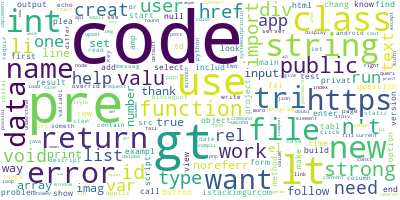

In [31]:
from wordcloud import WordCloud

# combine all stemmed tokens into one string
total_text = ' '.join(post for post in posts['merged'])

# initialize and generate wordcloud
wc = WordCloud(background_color='white', collocations=False)
wc.generate(total_text)
wc.to_image()

## Word cloud analysis

As expected, the word 'code' appears the most frequently within the Stack Overflow posts. Additionally, 'pre' and 'gt' appear very frequently, as well as some other programming keywords, such as 'string', 'class', 'return', etc. Given the size of the 'https' and the 'data' words, it may be interesting to analyze if the most frequently discussed topics are data analysis and web development.

## Latent Dirichlet Allocation (LDA) for Topic Modelling

LDA is a statistical model used for generating topics within documents that contain text data. LDA analyzes words that are frequently used together, and creates a word to topic distribution (probability), as well as a topic to document distribution (probability). Therefore, the output of LDA is the probability (based on the distributions) of a word belonging to a topic (based on how words are used together), and a probability of a topic belonging to a document.

The LDA model for this Stack Overflow analysis will generate 10 topics, with the top 10 words within each topic (based on probability distribution). 

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# initialize the vectorizer
vectorizer = CountVectorizer()

# create bag of words with vectorizer
word_counts = vectorizer.fit_transform(posts['merged'])

# create vector of all words in vocabulary (columns in the bag of words)
titles = vectorizer.get_feature_names()

# initialize LDA model with 10 topics
lda = LDA(n_components=10, random_state=0)

# fit the LDA model using bag of words as input
lda.fit(word_counts)

# print topic number and 10 words within the topic
for idx, topic in enumerate(lda.components_):
    # fetch last 10 indexes for sorted word scores from lda.components_ (AKA the 10 highest scored words)
    # use indexes of highest scored words to fetch the words themselves from the vectorizer column names (bag of words)
    topic_words = ' '.join([titles[i] for i in topic.argsort()[:-11:-1]])
    print('Topic: ', idx)
    print('Words: ', topic_words)

Topic:  0
Words:  code pre use gt string like error function valu tri
Topic:  1
Words:  id null androidlayout_width androidlayout_height true wrap_cont androidid fals match_par spring
Topic:  2
Words:  code use https li file href rel noreferr pre tri
Topic:  3
Words:  name code lib file pre users gems 2017 def ruby
Topic:  4
Words:  gt class div lt id text data name type button
Topic:  5
Words:  valu cell insert column name row tabl sheet excel id
Topic:  6
Words:  line file echo lib usr td python error users local
Topic:  7
Words:  int number print return array input valu string els char
Topic:  8
Words:  gt lt code pre return error compon function import react
Topic:  9
Words:  public new string class void import privat return code int


## Summary

The topics generated from the LDA analysis are sensible, based on the top 10 words for each topic. For example, Topic 1 appears to be Android development, Topic 2 and 4 appear to be HTML web development, Topic 3 appears to be Ruby, Topic 5 appears to be data analysis in Excel, Topic 8 appears to be React or some variant of JavaScript, and Topic 9 appears to be some variant of the C language (or another language).